<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Rate-Schedule-in-Practice:-an-example-with-Keras-and-TensorFlow-2.0" data-toc-modified-id="Learning-Rate-Schedule-in-Practice:-an-example-with-Keras-and-TensorFlow-2.0-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Learning Rate Schedule in Practice: an example with Keras and TensorFlow 2.0</a></span></li><li><span><a href="#Constant-learning-rate" data-toc-modified-id="Constant-learning-rate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Constant learning rate</a></span></li><li><span><a href="#Time-based-decay" data-toc-modified-id="Time-based-decay-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Time-based decay</a></span></li><li><span><a href="#Step-decay" data-toc-modified-id="Step-decay-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step decay</a></span></li><li><span><a href="#Exponential-decay" data-toc-modified-id="Exponential-decay-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exponential decay</a></span></li><li><span><a href="#Compare-model-accuracy" data-toc-modified-id="Compare-model-accuracy-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compare model accuracy</a></span></li></ul></div>

# Learning Rate Schedule in Practice: an example with Keras and TensorFlow 2.0

One of the painful things about training a neural network is the sheer number of hyperparameters we have to deal with. For example

    Learning rate
    Momentum or the hyperparameters for Adam optimization algorithm
    Number of layers
    Number of hidden units
    Mini-batch size
    Activation function
    etc
    
Among them, the most important parameter is the learning rate. If your learning rate is set to low, training will progress very slowly as you are making very tiny updates to the weights in your network. However, if your learning rate is set too high, it can cause undesirable divergent behavior in your loss function.

![](./i/16Zr7nkI97IGT9e_tpgK-_g.png)

When training a neural network, it is often useful to reduce the learning rate as the training progresses. This can be done by using learning rate schedules or adaptive learning rate. In this article, we will focus on adding and customizing learning rate schedule in our machine learning model and look at examples of how we do them in practice with Keras and TensorFlow 2.0
Learning Rate Schedules

Learning Rate Schedules seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined schedule. The popular learning rate schedules include

    Constant learning rate
    Time-based decay
    Step decay
    Exponential decay

For the demonstration purpose, we will build an image classifier to tackle Fashion MNIST, which is a dataset that has 70,000 grayscale images of 28-by-28 pixels with 10 classes.

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
# Fashion MMIST dataset

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
 
print(X_train_full.shape)
print(X_train_full.dtype)
# For faster training, let's use a subset 10,000
X_train, y_train = X_train_full[:10000] / 255.0, y_train_full[:10000]
X_train.shape, y_train.shape

(60000, 28, 28)
uint8


((10000, 28, 28), (10000,))

Our model has the following specifications:

    The first layer (also known as the input layer) has the input_shape to set the input size (28, 28) which matches the training data. The input layer is a Flatten layer whose role is simply to convert each input image into a 1D array.
    And then it is followed by 2 Dense layers, one with 300 units, and the other with 100 units. Both of them use the relu activation function.
    The output Dense layer has 10 units and the softmax activation function.

In [3]:
# Building a NN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_model(): 
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(300, activation='relu'),
        Dense(100, activation='relu'),
        Dense(10, activation='softmax'),
    ])
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_lr(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()
    
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

# Constant learning rate

The constant learning rate is the default schedule in all Keras Optimizers. For example, in the SGD optimizer, the learning rate defaults to 0.01.

To use a custom learning rate, simply instantiate an SGD optimizer and pass the argument learning_rate=0.01 .

In [18]:
# Create a new model
model = create_model()

# Learning rate defaults to 0.01 according to https://keras.io/api/optimizers/sgd/
# To use a custom Learning Rate
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    optimizer=sgd, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

history_constant = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 1s 64us/sample - loss: 1.6652 - accuracy: 0.5254 - val_loss: 1.2158 - val_accuracy: 0.6490
Epoch 2/100
8000/8000 [==============================] - 0s 29us/sample - loss: 1.0108 - accuracy: 0.6905 - val_loss: 0.9060 - val_accuracy: 0.7155
Epoch 3/100
8000/8000 [==============================] - 0s 30us/sample - loss: 0.8174 - accuracy: 0.7341 - val_loss: 0.7947 - val_accuracy: 0.7450
Epoch 4/100
8000/8000 [==============================] - 0s 29us/sample - loss: 0.7271 - accuracy: 0.7657 - val_loss: 0.7194 - val_accuracy: 0.7580
Epoch 5/100
8000/8000 [==============================] - 0s 33us/sample - loss: 0.6692 - accuracy: 0.7791 - val_loss: 0.6733 - val_accuracy: 0.7840
Epoch 6/100
8000/8000 [==============================] - 0s 35us/sample - loss: 0.6294 - accuracy: 0.7965 - val_loss: 0.6330 - val_accuracy: 0.7925
Epoch 7/100
8000/8000 [==============================] - 0s 32us

Epoch 56/100
8000/8000 [==============================] - 0s 29us/sample - loss: 0.3188 - accuracy: 0.8898 - val_loss: 0.4249 - val_accuracy: 0.8555
Epoch 57/100
8000/8000 [==============================] - 0s 31us/sample - loss: 0.3139 - accuracy: 0.8926 - val_loss: 0.4454 - val_accuracy: 0.8420
Epoch 58/100
8000/8000 [==============================] - 0s 30us/sample - loss: 0.3139 - accuracy: 0.8921 - val_loss: 0.4313 - val_accuracy: 0.8475
Epoch 59/100
8000/8000 [==============================] - 0s 28us/sample - loss: 0.3116 - accuracy: 0.8929 - val_loss: 0.4178 - val_accuracy: 0.8555
Epoch 60/100
8000/8000 [==============================] - 0s 28us/sample - loss: 0.3089 - accuracy: 0.8938 - val_loss: 0.4581 - val_accuracy: 0.8330
Epoch 61/100
8000/8000 [==============================] - 0s 28us/sample - loss: 0.3045 - accuracy: 0.8963 - val_loss: 0.4324 - val_accuracy: 0.8480
Epoch 62/100
8000/8000 [==============================] - 0s 29us/sample - loss: 0.3015 - accuracy: 0.8966

10000/1 - 0s - loss: 89.2896 - accuracy: 0.8049


[100.52442405090332, 0.8049]

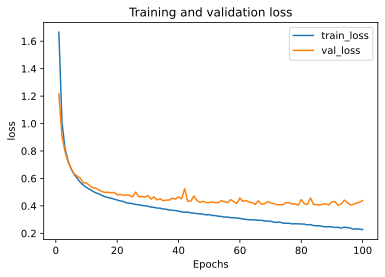

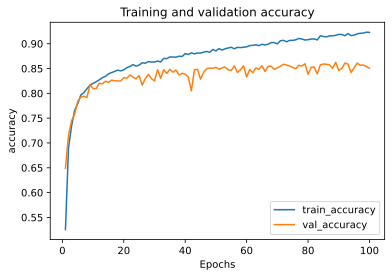

In [19]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)

plot_metric(history_constant, 'loss')
plot_metric(history_constant, 'accuracy')

# Time-based decay

Time-based decay is one of the most popular learning rate schedules. Formally, the time-based decay is defined as:

```python
learning_rate = lr * 1 / (1 + decay * epoch)
```

where lr is the previous learning rate, decay is a hyperparameter and epoch is the iteration number. When the decay is zero, this has no effect on changing the learning rate. When the decay is specified, it will decrease the learning rate from the previous epoch by the given fixed amount. The value of decay is normally implemented as
```python
decay = initial_learning_rate / num_of_epoches 
```
In Keras, one way to implement the time-based decay is by defining a time-based decay function lr_time_based_decay() and pass it to LearningRateScheduler callback.

In [11]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

history_time_based_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],
)

Train on 8000 samples, validate on 2000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/100
8000/8000 [==============================] - 1s 63us/sample - loss: 1.5208 - accuracy: 0.5609 - val_loss: 1.0960 - val_accuracy: 0.6485

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009998999876494932.
Epoch 2/100
8000/8000 [==============================] - 0s 31us/sample - loss: 0.9371 - accuracy: 0.6931 - val_loss: 0.8679 - val_accuracy: 0.6950

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009997000136010244.
Epoch 3/100
8000/8000 [==============================] - 0s 34us/sample - loss: 0.7848 - accuracy: 0.7358 - val_loss: 0.7617 - val_accuracy: 0.7305

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009994001785933966.
Epoch 4/100
8000/8000 [==============================] - 0s 38us/sample - loss: 0.7079 - accuracy: 0.7591 - val_loss: 0.7025 - val_accuracy: 0.7555

Epoch 00005: LearningRa

8000/8000 [==============================] - 0s 33us/sample - loss: 0.3667 - accuracy: 0.8766 - val_loss: 0.4504 - val_accuracy: 0.8445

Epoch 00037: LearningRateScheduler reducing learning rate to 0.00935645021227975.
Epoch 37/100
8000/8000 [==============================] - 0s 31us/sample - loss: 0.3643 - accuracy: 0.8758 - val_loss: 0.4504 - val_accuracy: 0.8400

Epoch 00038: LearningRateScheduler reducing learning rate to 0.009321959041036006.
Epoch 38/100
8000/8000 [==============================] - 0s 30us/sample - loss: 0.3591 - accuracy: 0.8760 - val_loss: 0.4400 - val_accuracy: 0.8485

Epoch 00039: LearningRateScheduler reducing learning rate to 0.009286669414163135.
Epoch 39/100
8000/8000 [==============================] - 0s 29us/sample - loss: 0.3595 - accuracy: 0.8741 - val_loss: 0.4566 - val_accuracy: 0.8410

Epoch 00040: LearningRateScheduler reducing learning rate to 0.009250591775017058.
Epoch 40/100
8000/8000 [==============================] - 0s 30us/sample - loss: 0

8000/8000 [==============================] - 0s 28us/sample - loss: 0.2868 - accuracy: 0.9021 - val_loss: 0.4334 - val_accuracy: 0.8485

Epoch 00072: LearningRateScheduler reducing learning rate to 0.007749216934560059.
Epoch 72/100
8000/8000 [==============================] - 0s 29us/sample - loss: 0.2825 - accuracy: 0.9044 - val_loss: 0.4200 - val_accuracy: 0.8520

Epoch 00073: LearningRateScheduler reducing learning rate to 0.007693821581330584.
Epoch 73/100
8000/8000 [==============================] - 0s 28us/sample - loss: 0.2797 - accuracy: 0.9047 - val_loss: 0.4162 - val_accuracy: 0.8575

Epoch 00074: LearningRateScheduler reducing learning rate to 0.007638063699311773.
Epoch 74/100
8000/8000 [==============================] - 0s 31us/sample - loss: 0.2787 - accuracy: 0.9057 - val_loss: 0.4318 - val_accuracy: 0.8500

Epoch 00075: LearningRateScheduler reducing learning rate to 0.007581957263684542.
Epoch 75/100
8000/8000 [==============================] - 0s 33us/sample - loss: 

10000/1 - 0s - loss: 97.3350 - accuracy: 0.8024


[102.53265984191894, 0.8024]

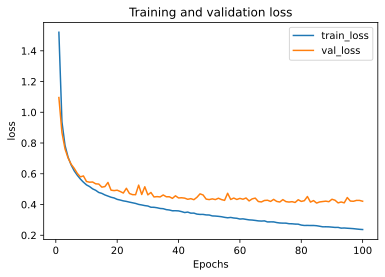

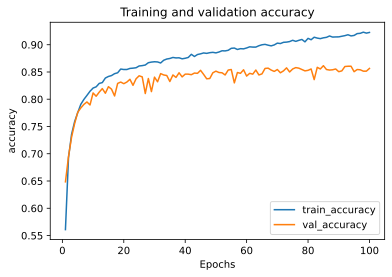

In [12]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)

plot_metric(history_time_based_decay, 'loss')
plot_metric(history_time_based_decay, 'accuracy')

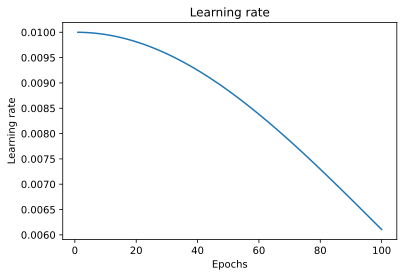

In [16]:
plot_lr(history_time_based_decay)

# Step decay

Another popular learning rate schedule is to systematically drop the learning rate at specific times during training. Formally, it is defined as:
```python
learning_rate = initial_lr * drop_rate^floor(epoch / epochs_drop)
```
Where initial_lr is the initial learning rate such as 0.01, the drop_rate is the amount that the learning rate is modified each time if it is changed, epoch is the current epoch number, and epochs_drop is how often to change the learning rate such as 10 epochs. Similarly, we can implement this by defining a step decay function lr_step_decay() and pass it to LearningRateScheduler callback.

In [13]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
# Define the learning rate schedule function
initial_learning_rate = 0.01

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Fit the model to the training data
history_step_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)],
)

Train on 8000 samples, validate on 2000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
8000/8000 [==============================] - 1s 80us/sample - loss: 1.5265 - accuracy: 0.5536 - val_loss: 1.1042 - val_accuracy: 0.6660

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
8000/8000 [==============================] - 0s 31us/sample - loss: 0.9405 - accuracy: 0.7001 - val_loss: 0.8762 - val_accuracy: 0.7215

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
8000/8000 [==============================] - 0s 36us/sample - loss: 0.7873 - accuracy: 0.7402 - val_loss: 0.7695 - val_accuracy: 0.7375

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
Epoch 4/100
8000/8000 [==============================] - 0s 35us/sample - loss: 0.7100 - accuracy: 0.7669 - val_loss: 0.7120 - val_accuracy: 0.7640

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
Epoch 5/100
8000/800

8000/8000 [==============================] - 0s 33us/sample - loss: 0.4365 - accuracy: 0.8560 - val_loss: 0.4943 - val_accuracy: 0.8325

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00125.
Epoch 39/100
8000/8000 [==============================] - 0s 30us/sample - loss: 0.4360 - accuracy: 0.8544 - val_loss: 0.4940 - val_accuracy: 0.8320

Epoch 00040: LearningRateScheduler reducing learning rate to 0.00125.
Epoch 40/100
8000/8000 [==============================] - 0s 29us/sample - loss: 0.4350 - accuracy: 0.8580 - val_loss: 0.4954 - val_accuracy: 0.8295

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
Epoch 41/100
8000/8000 [==============================] - 0s 31us/sample - loss: 0.4332 - accuracy: 0.8566 - val_loss: 0.4927 - val_accuracy: 0.8345

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
Epoch 42/100
8000/8000 [==============================] - 0s 32us/sample - loss: 0.4331 - accuracy: 0.8564 - val_loss: 0.4934 - val

8000/8000 [==============================] - 0s 32us/sample - loss: 0.4255 - accuracy: 0.8591 - val_loss: 0.4881 - val_accuracy: 0.8340

Epoch 00076: LearningRateScheduler reducing learning rate to 7.8125e-05.
Epoch 76/100
8000/8000 [==============================] - 0s 30us/sample - loss: 0.4254 - accuracy: 0.8599 - val_loss: 0.4880 - val_accuracy: 0.8340

Epoch 00077: LearningRateScheduler reducing learning rate to 7.8125e-05.
Epoch 77/100
8000/8000 [==============================] - 0s 29us/sample - loss: 0.4254 - accuracy: 0.8599 - val_loss: 0.4880 - val_accuracy: 0.8345

Epoch 00078: LearningRateScheduler reducing learning rate to 7.8125e-05.
Epoch 78/100
8000/8000 [==============================] - 0s 31us/sample - loss: 0.4253 - accuracy: 0.8599 - val_loss: 0.4880 - val_accuracy: 0.8350

Epoch 00079: LearningRateScheduler reducing learning rate to 7.8125e-05.
Epoch 79/100
8000/8000 [==============================] - 0s 30us/sample - loss: 0.4253 - accuracy: 0.8595 - val_loss: 0.

10000/1 - 0s - loss: 53.2821 - accuracy: 0.8046


[73.80366096506118, 0.8046]

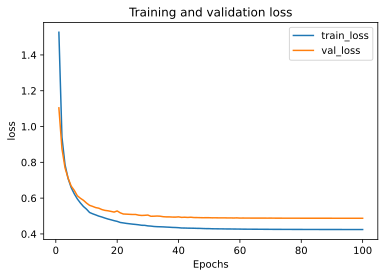

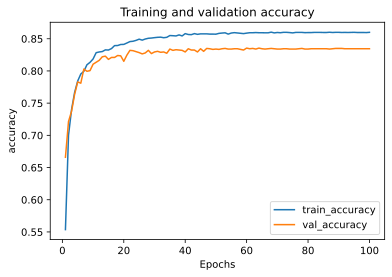

In [14]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)

plot_metric(history_step_decay , 'loss')
plot_metric(history_step_decay , 'accuracy')

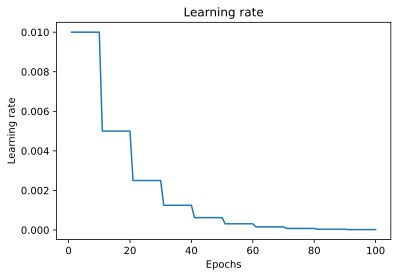

In [15]:
plot_lr(history_step_decay)

# Exponential decay

Another popular learning rate schedule is to drop the learning rate at an exponential rate. Formally, it is defined as:
```python
learning_rate = initial_lr * e^(−k * epoch)
```
Where initial_lr is the initial learning rate such as 0.01, k is a hyperparameter, and epoch is the current epoch number. Similarly, we can implement this by defining an exponential decay function lr_exp_decay() and pass it to LearningRateScheduler callback.

In [21]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

initial_learning_rate = 0.01

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

# Fit the model to the training data
history_exp_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_exp_decay, verbose=1)],
)

Train on 8000 samples, validate on 2000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
8000/8000 [==============================] - 0s 61us/sample - loss: 1.6252 - accuracy: 0.5415 - val_loss: 1.1647 - val_accuracy: 0.6675

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009048374180359595.
Epoch 2/100
8000/8000 [==============================] - 0s 31us/sample - loss: 0.9874 - accuracy: 0.6891 - val_loss: 0.8990 - val_accuracy: 0.6955

Epoch 00003: LearningRateScheduler reducing learning rate to 0.008187307530779819.
Epoch 3/100
8000/8000 [==============================] - 0s 32us/sample - loss: 0.8235 - accuracy: 0.7190 - val_loss: 0.8094 - val_accuracy: 0.7140

Epoch 00004: LearningRateScheduler reducing learning rate to 0.007408182206817179.
Epoch 4/100
8000/8000 [==============================] - 0s 33us/sample - loss: 0.7520 - accuracy: 0.7405 - val_loss: 0.7531 - val_accuracy: 0.7420

Epoch 00005: LearningRateScheduler redu


Epoch 00036: LearningRateScheduler reducing learning rate to 0.00030197383422318503.
Epoch 36/100
8000/8000 [==============================] - 0s 34us/sample - loss: 0.5174 - accuracy: 0.8316 - val_loss: 0.5625 - val_accuracy: 0.8070

Epoch 00037: LearningRateScheduler reducing learning rate to 0.0002732372244729256.
Epoch 37/100
8000/8000 [==============================] - 0s 34us/sample - loss: 0.5171 - accuracy: 0.8322 - val_loss: 0.5622 - val_accuracy: 0.8070

Epoch 00038: LearningRateScheduler reducing learning rate to 0.00024723526470339386.
Epoch 38/100
8000/8000 [==============================] - 0s 38us/sample - loss: 0.5165 - accuracy: 0.8315 - val_loss: 0.5621 - val_accuracy: 0.8065

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00022370771856165591.
Epoch 39/100
8000/8000 [==============================] - 0s 41us/sample - loss: 0.5162 - accuracy: 0.8332 - val_loss: 0.5616 - val_accuracy: 0.8065

Epoch 00040: LearningRateScheduler reducing learning rate to


Epoch 00071: LearningRateScheduler reducing learning rate to 9.118819655545163e-06.
Epoch 71/100
8000/8000 [==============================] - 0s 38us/sample - loss: 0.5125 - accuracy: 0.8338 - val_loss: 0.5589 - val_accuracy: 0.8085

Epoch 00072: LearningRateScheduler reducing learning rate to 8.25104923265904e-06.
Epoch 72/100
8000/8000 [==============================] - 0s 34us/sample - loss: 0.5125 - accuracy: 0.8335 - val_loss: 0.5589 - val_accuracy: 0.8085

Epoch 00073: LearningRateScheduler reducing learning rate to 7.465858083766792e-06.
Epoch 73/100
8000/8000 [==============================] - 0s 30us/sample - loss: 0.5125 - accuracy: 0.8336 - val_loss: 0.5589 - val_accuracy: 0.8085

Epoch 00074: LearningRateScheduler reducing learning rate to 6.755387751938438e-06.
Epoch 74/100
8000/8000 [==============================] - 0s 28us/sample - loss: 0.5125 - accuracy: 0.8339 - val_loss: 0.5589 - val_accuracy: 0.8085

Epoch 00075: LearningRateScheduler reducing learning rate to 6.1

10000/1 - 0s - loss: 53.0632 - accuracy: 0.7826


[66.58981980743408, 0.7826]

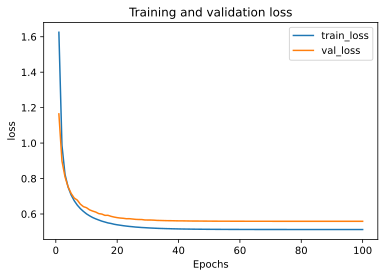

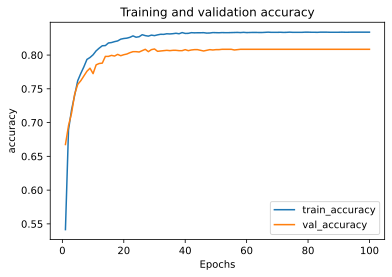

In [23]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)

plot_metric(history_exp_decay , 'loss')
plot_metric(history_exp_decay , 'accuracy')

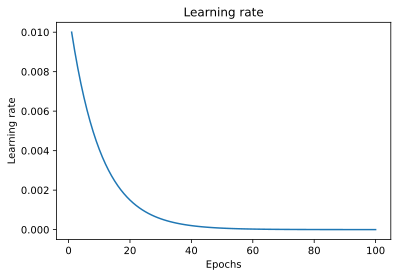

In [24]:
plot_lr(history_exp_decay)

# Compare model accuracy

Finally, let us compare the model accuracy using different learning rate schedules.

Looks like Constant and Time-based learning rates have better performance than Step decay and Exponential decay for this particular tutorial. Bear in mind that, this tutorial only uses the first 10,000 images with some arbitrary value forinitial_learning_rate=0.01, validation_split=0.2 and batch_size=64 .

Text(0.5, 0, 'epochs')

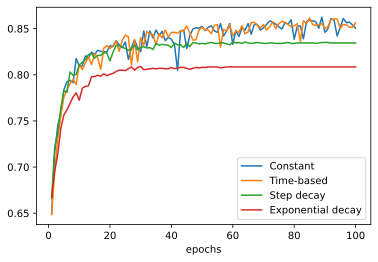

In [25]:
epochs = range(1, 101)
plt.plot(epochs,history_constant.history['val_accuracy'],label='Constant')
plt.plot(epochs,history_time_based_decay.history['val_accuracy'],label='Time-based')
plt.plot(epochs,history_step_decay.history['val_accuracy'],label='Step decay')
plt.plot(epochs,history_exp_decay.history['val_accuracy'],label='Exponential decay')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.show()

Text(0.5, 0, 'epochs')

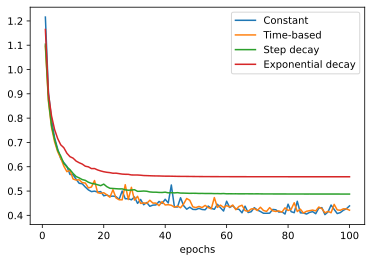

In [26]:
epochs = range(1, 101)
plt.plot(epochs,history_constant.history['val_loss'],label='Constant')
plt.plot(epochs,history_time_based_decay.history['val_loss'],label='Time-based')
plt.plot(epochs,history_step_decay.history['val_loss'],label='Step decay')
plt.plot(epochs,history_exp_decay.history['val_loss'],label='Exponential decay')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.show()